## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.groupby('group').agg(['min','max']).date

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
temp_data = data[['group', 'purchase', 'price']].groupby('group').agg(['count', 'sum'])
display(temp_data)
print(f"Количество посещений сайта в группах А ({temp.iloc[0,0]}) и B ({temp.iloc[1,0]})")
print(f"Cуммарное количество покупок в группах А ({temp.iloc[0,1]}) и B ({temp.iloc[1,1]})")
print(f"Cумма всех покупок (млн. руб.) в группах А ({temp.iloc[0,3]/1000000}) и B ({temp.iloc[1,3]/1000000})")

purchase          price            
         count    sum   count         sum
group                                    
A       147202  17723  147202  1436260000
B       147276  17514  147276  1554100000

NameError: name 'temp' is not defined

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [9]:
user_intersection = set(data[data.group =='A'].user_id).intersection(set(data[data.group =='B'].user_id))
print(f"Кол-во пользователей, попавших в обе группы: {len(user_intersection)}")

Кол-во пользователей, попавших в обе группы: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [10]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
display(updated_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290688 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   290688 non-null  int64         
 1   date      290688 non-null  datetime64[ns]
 2   group     290688 non-null  object        
 3   purchase  290688 non-null  int64         
 4   price     290688 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 13.3+ MB


None

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

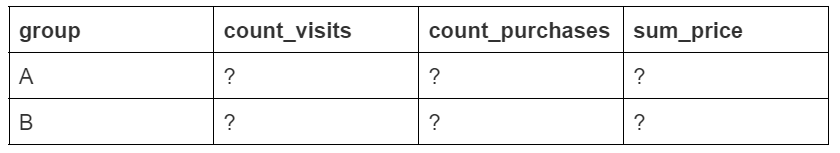
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [11]:
updated_data_grouped = updated_data.groupby(['group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'count_visits',
    'purchase':'count_purchases',
    'price':'sum_price'})

display(updated_data_grouped)

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

<span style=color:blue>**Промежуточные выводы по построенной таблице updated_data_grouped:**

>*Текущая выборка представлена достаточно большим количеством данных, а именно:*
>* Группа А: 145307
>* Группа Б: 145381
>
>*Также обе выборки практически одинаковы по размеру. Разница в размерности составляет около 0.05%, что ничтожно мало.*
>
>*Так что процентное соотношение выборок можно сказать 50/50 - сбалансированное.*

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [12]:
updated_data_grouped['conversion'] = updated_data_grouped['count_purchases'] / updated_data_grouped['count_visits'] * 100
updated_data_grouped['mean_check'] = updated_data_grouped['sum_price'] / updated_data_grouped['count_purchases']
updated_data_grouped.head()

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


In [13]:
print(f"Конверсия в группах (%): А - {round(updated_data_grouped.conversion[0],2)}, B - {round(updated_data_grouped.conversion[1], 2)}")
print(f"Средний чек в группах (руб): А - {round(updated_data_grouped.mean_check[0])}, B - {round(updated_data_grouped.mean_check[1])}")

Конверсия в группах (%): А - 12.03, B - 11.89
Средний чек в группах (руб): А - 81076, B - 88665


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

<span style=color:blue>**Промежуточные выводы по таблице updated_data_grouped (*с конверсией и средним чеком*):**

>На данный момент можно наблюдать что конверсия в группе А незначительно выше, чем в группе B
>
>*Что в процентном выражении составляет чуть более 1%*
>
>Однако, если мы пронаблюдаем разницу в размере среднего чека, то при немного меньшей конверсии, в группе В размер чека является больше 88665 против 81076 руб.
>
>*что в процентном выражении составляет 9% (средний чек в группе В больше среднего чека группы А).*


## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [14]:
updated_data_buytours = pd.pivot_table(updated_data[updated_data.purchase == 1]\
    [['group','purchase','price']],\
    index = 'price', columns='group', aggfunc='count').purchase
display(updated_data_buytours)

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

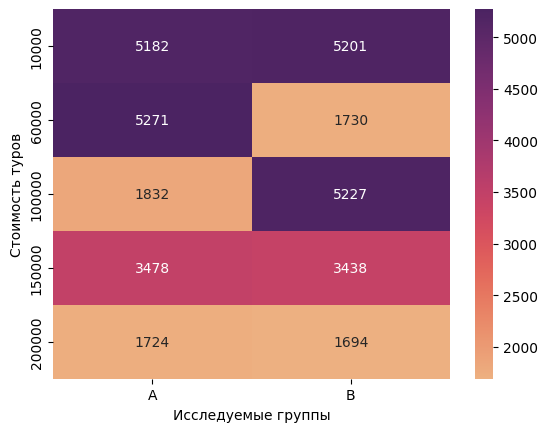

In [15]:
ax = sns.heatmap(
  updated_data_buytours,
  annot=True,
  fmt='.0f',
  cmap='flare')
ax.set(ylabel="Стоимость туров", xlabel="Исследуемые группы");

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

<span style=color:blue>**Промежуточные выводы по построеной таблице и тепловой карте:**

>* Как мы видим из полученных данных (таблица и тепловая карта), туры по цене 10.000, 150.000 и 200.000 руб в обеих группах были куплены примерно в пропорциях 50/50.
>
>* Однако, соотношение проданных туров по 60.000 и 100.000 руб не сбалансировано - группа А купила 75% туров за 60.000 руб, а группа Б - 77% туров за 100.000 руб.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [16]:
updated_data_daily = updated_data.groupby(['date','group']).agg({
    'user_id':'count',
    'purchase':'sum',
    'price': 'sum'
}).reset_index().rename(columns={
    'user_id': 'visits_count',
    'purchase':'purchased_count',
    'price':'purchased_sum'})

updated_data_daily['conversion'] = updated_data_daily['purchased_count'] / updated_data_daily['visits_count'] * 100
updated_data_daily['mean_check'] = updated_data_daily['purchased_sum'] / updated_data_daily['purchased_count']

display(updated_data_daily[updated_data_daily.date == '2021-01-03'][['group','conversion']].round(2))
display(updated_data_daily[updated_data_daily.date == '2021-01-03'][['group','mean_check']].round())

,group,conversion
2,A,11.34
3,B,11.39


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [17]:
updated_data_daily.head()

,date,group,visits_count,purchased_count,purchased_sum,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270


In [18]:
updated_data_daily['cum_visits_count'] = updated_data_daily.groupby(['group'])['visits_count'].cumsum()
updated_data_daily['cum_purchased_count'] = updated_data_daily.groupby(['group'])['purchased_count'].cumsum()
updated_data_daily['cum_purchased_sum'] = updated_data_daily.groupby(['group'])['purchased_sum'].cumsum()

updated_data_daily['cum_conversion'] = updated_data_daily['cum_purchased_count'] / updated_data_daily['cum_visits_count'] * 100
updated_data_daily['cum_mean_check'] = updated_data_daily['cum_purchased_sum'] / updated_data_daily['cum_purchased_count']

display(f"Кумулятивная конверсия в группе B на 20 января: \
{updated_data_daily[(updated_data_daily['date'] == '2021-01-20') & (updated_data_daily['group'] == 'B')].cum_conversion.round(2).item()}")
display(f"Кумулятивный средний чек в группе А на 12 января: \
{updated_data_daily[(updated_data_daily['date'] == '2021-01-12') & (updated_data_daily['group'] == 'A')].cum_mean_check.round(0).item()}")


'Кумулятивная конверсия в группе B на 20 января: 11.9'

'Кумулятивный средний чек в группе А на 12 января: 81492.0'

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

In [19]:
updated_data_daily.head()

,date,group,visits_count,purchased_count,purchased_sum,conversion,mean_check,cum_visits_count,cum_purchased_count,cum_purchased_sum,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530


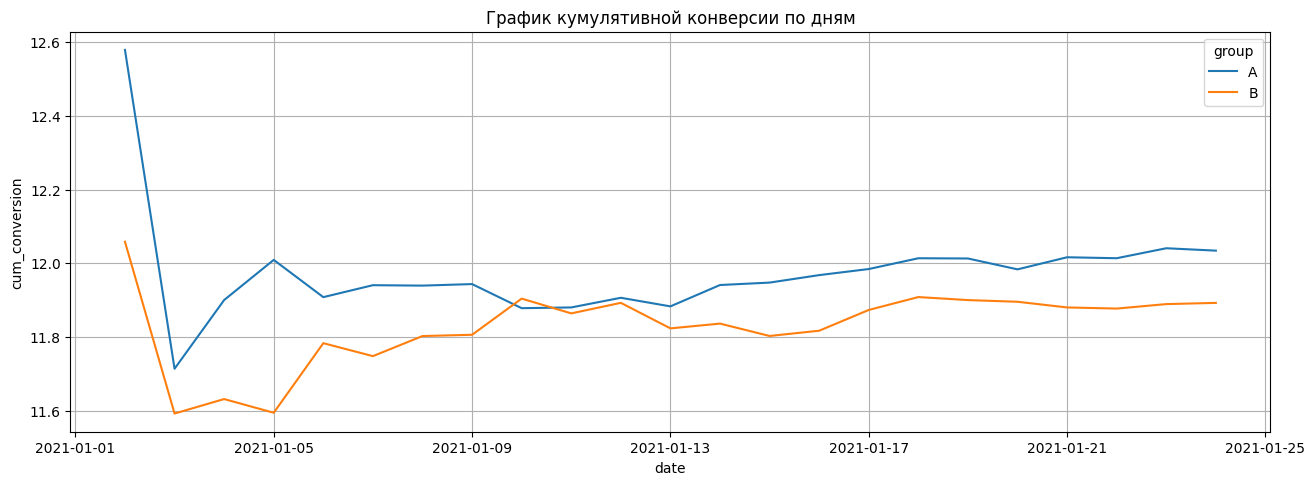

In [22]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(12, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии по дням в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=updated_data_daily, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 0)
# задаём отображение сетки
ax.grid(True);

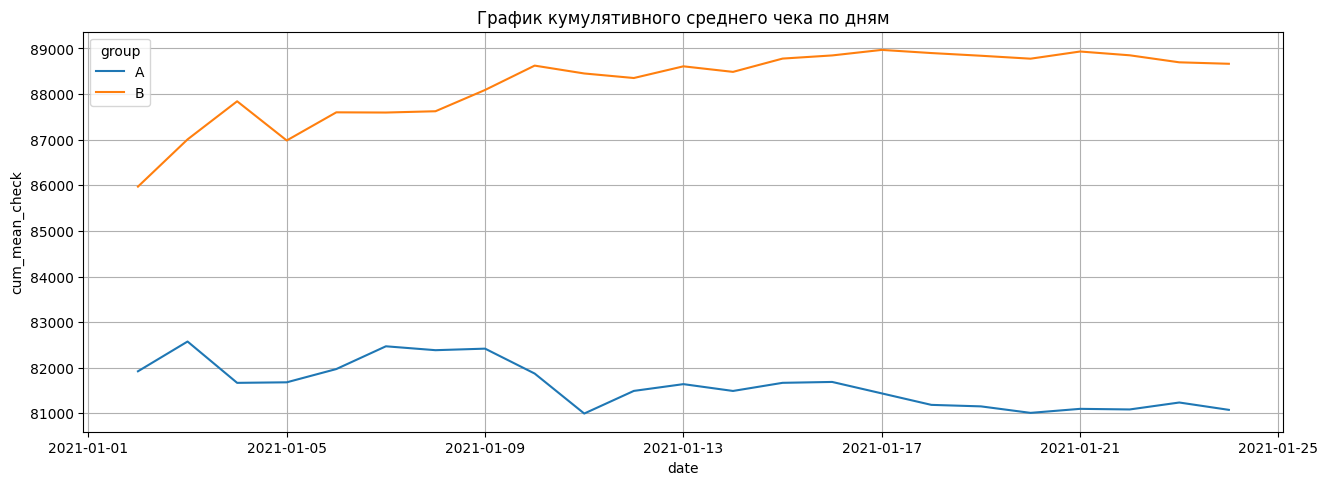

In [23]:
# создаём фигуру размером 12x4
fig = plt.figure(figsize=(12, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивного среднего чека по дням в каждой группе
sns.lineplot(x='date', y='cum_mean_check', data=updated_data_daily, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 0)
# задаём отображение сетки
ax.grid(True);

<span style=color:blue>**Промежуточные выводы по кумулятивным графикам конверсии и среднего чека в каждой группе по дням:**

>* Анализ графиков кумулятивной конверсии и кумулятивного среднего чека по дням показывает, что скачки наблюдались до 12 января 2021 года для обеих графиков. Далее показатели на графиках стабилизировались.
>
>* После стабилизации графиков мы можем наблюдать, что что конверсия в группе А ненамного выше, чем в группе Б (*примерно на 0.2-0.3%*)
>
>* В то же время, на графике кумулятивного среднего чека Группа Б лидирует на всем временном отрезке (*после  стабилизации, разница составляет примерно 7 тысяч руб в день*).

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [ ]:
converted_piv= updated_data.groupby('group')['purchase'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17487,145307
B,17290,145381


In [ ]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

<span style=color:blue>**Промежуточные выводы по по результатам проведенного статистического теста:**

>*Статистическая разница между конверсиями в группах А и Б очень мала, поэтому мы не можем опровергнуть нулевую гипотезу гипотезу о том, что конверсии в группах А и Б равны.*
>
>*Так что исходя из этого, статистической разницы между конверсиями нет.*

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [24]:
#фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
#фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']
display(a_data.head())

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
4,864975,2021-01-21,A,1,150000
5,936923,2021-01-10,A,0,0
7,719014,2021-01-17,A,0,0


In [25]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


In [26]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['purchase'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['purchase'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [27]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [28]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

<span style=color:blue>**Промежуточные выводы доверительным интервалам для конверсий в группах:**

>* *Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.09 %.* 
>* *То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0. Отсюда можно сделать вывод, что статистической разницы в конверсии групп А и B не существует, то есть они являются равнозначными по данной метрике.*

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

p=0.253
Данные распределены нормально (Группа A)
p=0.094
Данные распределены нормально (Группа B)


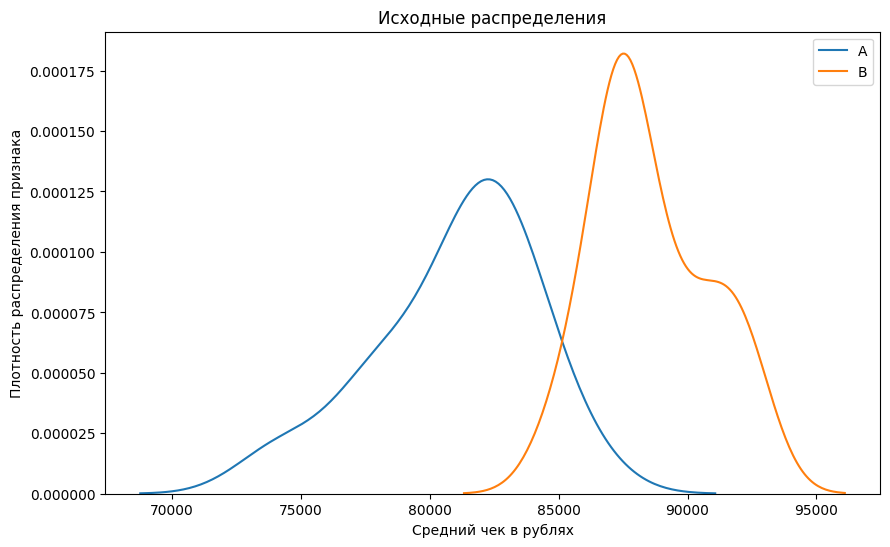

In [33]:
#фильтруем данные группы А
a_daily_data = updated_data_daily[updated_data_daily['group'] == 'A']['mean_check']
#фильтруем данные группы B
b_daily_data = updated_data_daily[updated_data_daily['group'] == 'B']['mean_check']

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
alpha = 0.05

_, p = shapiro(a_daily_data)
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0, '(Группа A)')
else:
	print(Ha, '(Группа A)')

_, p = shapiro(b_daily_data)
print('p=%.3f' % p)
# Интерпретация 
if p > alpha:
	print(H0, '(Группа B)')
else:
	print(Ha, '(Группа B)')
 
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 6))
ax1.set_title('Исходные распределения')
ax1.set(xlabel='Средний чек в рублях', ylabel='Плотность распределения признака')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(updated_data_daily[updated_data_daily.group == 'A'].mean_check, ax=ax1, label ='A')
sns.kdeplot(updated_data_daily[updated_data_daily.group == 'B'].mean_check, ax=ax1, label ='B')

plt.legend();

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [42]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
# вычисляем результат T-теста для выборок используя отфильтрованные данные из Задания 7.12
test_results = ttest_ind(
    a=a_daily_data,
    b=b_daily_data, 
    alternative='less'
)

p = test_results[1]
print('\n' + "*** Результаты независимого T-теста ***")
 
if p < alpha:
    print(f"{p} < {alpha}. Отвергаем нулевую гипотезу: '{H0}'")
    print(f"Альтернативная гипотеза: '{H1}'")
else:
    print(f"Принимаем нулевую гипотезу: '{H0}'")


*** Результаты независимого T-теста ***
p-value: 0.0
1.1261794674808954e-12 < 0.05. Отвергаем нулевую гипотезу: 'Ежедневные средние чеки в группах А и B равны'
Альтернативная гипотеза: 'Ежедневный средний чек в группе А меньше, чем в группе B'


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

<span style=color:blue>**Промежуточные выводы по по проведенному статистическому тесту:**

>* *Т-тест показал, что мы не можем подтвердить нулевую гипотезу, утверждающую, что размер среднего дневного чека равен в обеих группах.*
>* *Т.е ежедневнй чек в группе Б с вероятностью 95% больше среднего чека из группы А*

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [45]:
def check_conf_interval(n, x_mean, x_std, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, n-1) # t-критическое

    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    return ('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

display('Группа А: {}'.format(check_conf_interval(
  updated_data_daily[updated_data_daily.group == 'A'].shape[0],
  updated_data_daily[updated_data_daily.group == 'A'].mean_check.mean(),
  updated_data_daily[updated_data_daily.group == 'A'].mean_check.std()
)))

display('Группа Б: {}'.format(check_conf_interval(
  updated_data_daily[updated_data_daily.group == 'B'].shape[0],
  updated_data_daily[updated_data_daily.group == 'B'].mean_check.mean(),
  updated_data_daily[updated_data_daily.group == 'B'].mean_check.std()
)))

'Группа А: Доверительный интервал: (79630, 82308)'

'Группа Б: Доверительный интервал: (87626, 89526)'

Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

<span style=color:blue>**Промежуточные выводы по построенным доверительным интервалам для ежедневных средних чеков в группах:**

>* *Между доверительными интервалами нет пересечений, т.е мы с 95% вероятностью можем утверждать, что существует разница в размере среднего чека в зависимости от группы.*
>* *Таким образом, ежедневный средний чек в группе Б больше, чем в группе A*

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

>* Сложно сделать однозначный вывод относительно эффективности дизайна посадочной страницы.
>* Исходя из ограниченных входных данных, мы знаем только цену тура, но не знаем какой тур более маржинальный для компании - за 60.000 руб или за 100.000 руб.
>* Cредний дневной чек в группе Б более высокий (ок. 7000 руб) за счет того, что туры за 100.000 руб продаются чаще, по сравнению с турами за 60.000 руб в группе А.
>* В то же время конверсия в группе А немного выше, чем в группе Б.
>* В случае, если маржинальность продажи пропорциональна стоимости тура, то вариант страницы у группы Б предпочтительнее.
>* Однако, стоит учесть, что разница дизайнов страницы затрагивает лишь 2 тура из всех предложенных. Остальные туры продаются примерно на одинаковом уровне в обеих группах.
>* Также, конверсия в группе А немного выше, что говорит о потенциале увеличения количества продаж туров.

<span style=color:blue>**Итак, в группе Б более высокий средний чек (потенциально более высокая маржинальность), в группе А - более высокая конверсия (потенциал роста продаж туров).**

*Краткосрочная стратегия - выбор группы Б, долгосрочная стратегия - продолжить исследования и внести корректировки в новый дизайн, чтобы получить одновременно более высокую конверсию и увеличение среднего чека*